In [1]:
from dichasus_cf0x import test_set, spec
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm.auto import tqdm

2024-02-10 16:41:41.927924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 16:41:42.607751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-10 16:41:43.549885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:41:43.574522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
test_set_positions = np.load("results/test_set_positions.npy")
test_set_csi_gan_randomnoise = np.load("results/test_set_csi_gan_randomnoise.npy")
test_set_csi_gan_fixednoise = np.load("results/test_set_csi_gan_fixednoise.npy")
test_set_csi_interpolated = np.load("results/test_set_csi_interpolated.npy")
test_set_csi_interpolated_valid = np.load("results/test_set_csi_interpolated_valid.npy")

In [3]:
# Use "training set" CSI to predict CSI at test set positions
test_set_csi_cplx = []

with tqdm(total = len(test_set_positions)) as pbar:
    for csi, pos, time, ds in test_set.batch(100):
        test_set_csi_cplx.append(csi.numpy())
        pbar.update(tf.shape(csi)[0].numpy())

test_set_csi_cplx = np.concatenate(test_set_csi_cplx)

  0%|          | 0/20973 [00:00<?, ?it/s]

In [4]:
test_set_csi = np.stack([np.real(test_set_csi_cplx), np.imag(test_set_csi_cplx)], axis = -1)

In [5]:
def get_unitary_rootmusic_estimator(chunksize = 32):
    I = np.eye(chunksize // 2)
    J = np.flip(np.eye(chunksize // 2), axis = -1)
    Q = np.asmatrix(np.block([[I, 1.0j * I], [J, -1.0j * J]]) / np.sqrt(2))

    def unitary_rootmusic(R):
        assert(len(R) == chunksize)
        C = np.real(Q.H @ R @ Q)
    
        eig_val, eig_vec = np.linalg.eigh(C)
        eig_val = eig_val[::-1]
        eig_vec = eig_vec[:,::-1]

        source_count = 1
        En = eig_vec[:,source_count:]
        ENSQ = Q @ En @ En.T @ Q.H
    
        coeffs = np.asarray([np.trace(ENSQ, offset = diag) for diag in range(1, len(R))])

        coeffs = np.hstack((coeffs[::-1], np.trace(ENSQ), coeffs.conj()))
        roots = np.roots(coeffs)
        roots = roots[abs(roots) < 1.0]
        largest_root = np.argmax(1 / (1.0 - np.abs(roots)))

        return np.angle(roots[largest_root])

    return unitary_rootmusic

umusic = get_unitary_rootmusic_estimator(chunksize = 4)

In [6]:
def plot_aoa(title, positions, generated_csi, valid = None):
    csi_cplx = generated_csi[...,0] + 1.0j * generated_csi[...,1]
    aoa_all = np.zeros((len(generated_csi), len(generated_csi[0])))

    for l, csi in enumerate(tqdm(csi_cplx)):
        Rhat_allarrays = 1 / (np.shape(csi)[1] * np.shape(csi)[3]) * np.einsum("arct,ardt->acd", csi, np.conj(csi))
    
        for arrayidx, Rhat in enumerate(Rhat_allarrays):
            aoa_all[l, arrayidx] = -np.arcsin(umusic(Rhat) / np.pi)

    if valid is None:
        valid = np.arange(len(csi_cplx))
    else:
        valid = np.argwhere(valid).flatten()

    def sum_aoa(angles):
        return np.angle(np.sum(np.exp(1.0j * np.asarray(angles))))
    
    for ant in range(tf.shape(aoa_all)[1].numpy()):
        plt.figure(figsize=(7, 7))
        plt.title(title + ": Delay Spread - Antenna " + str(ant))
        plt.hexbin(positions[valid,0], positions[valid,1], C = aoa_all[valid,ant], reduce_C_function = sum_aoa, cmap = "twilight", gridsize = 40, vmin = -np.pi / 2, vmax = np.pi / 2)
        plt.xlabel("Transmitter Position x [m]")
        plt.ylabel("Transmitter Position y [m]")
        plt.xlim((-12.5, 2.5))
        plt.ylim((-15.5, -0.5))
        plt.colorbar(label = "Angle of Arrival [rad]")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.title(title + ": AoA Histogram - Antenna " + str(ant))
        plt.xlabel("Delay Spread")
        plt.ylabel("Occurences")
        plt.hist(aoa_all[valid,ant], bins = 50, range = (-np.pi / 2, np.pi / 2))
        plt.show()

### Generate Plots

  0%|          | 0/20973 [00:00<?, ?it/s]

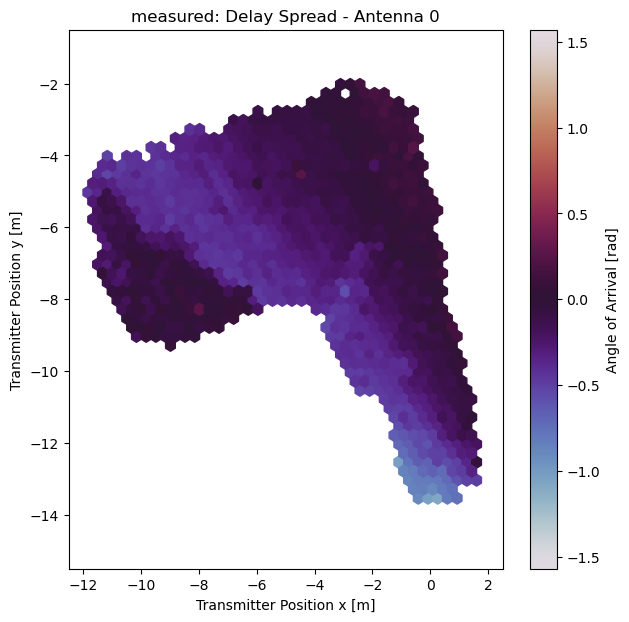

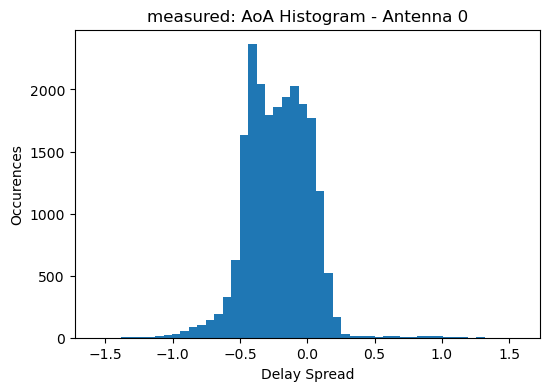

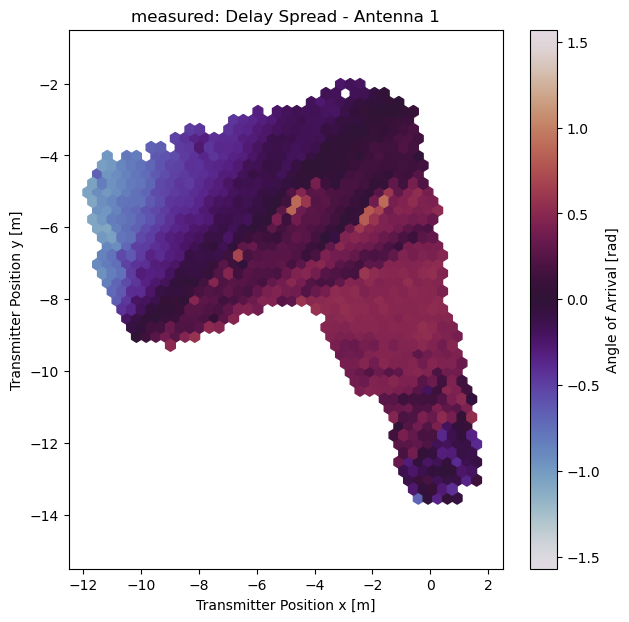

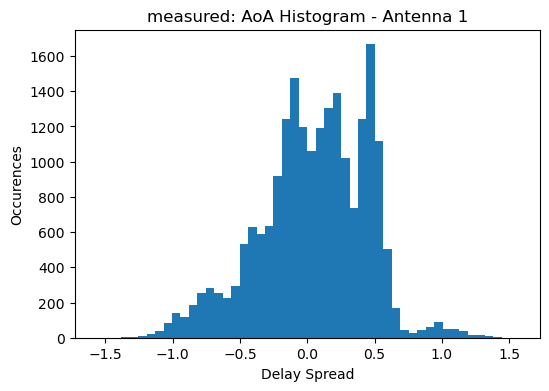

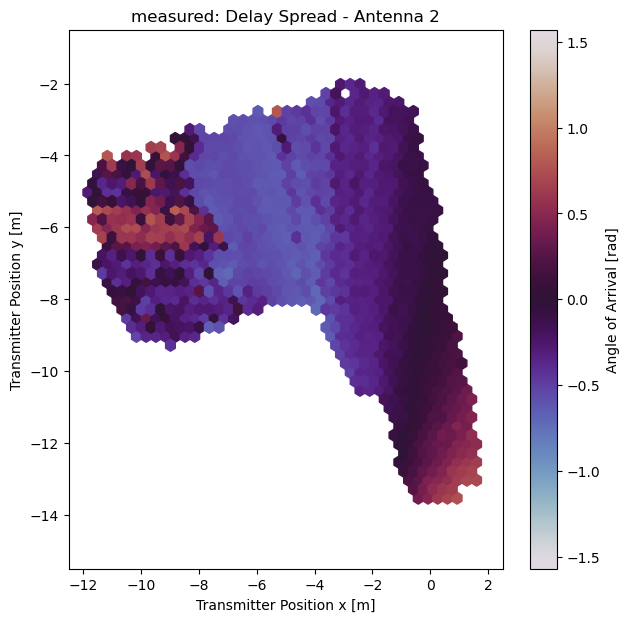

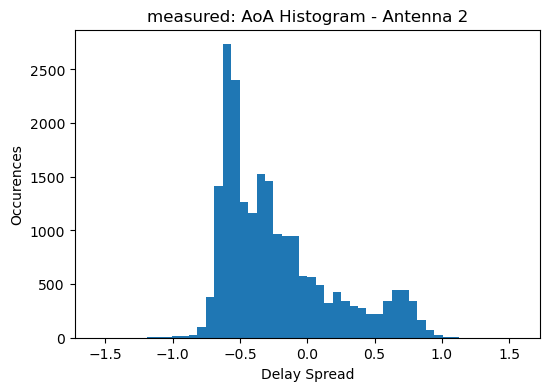

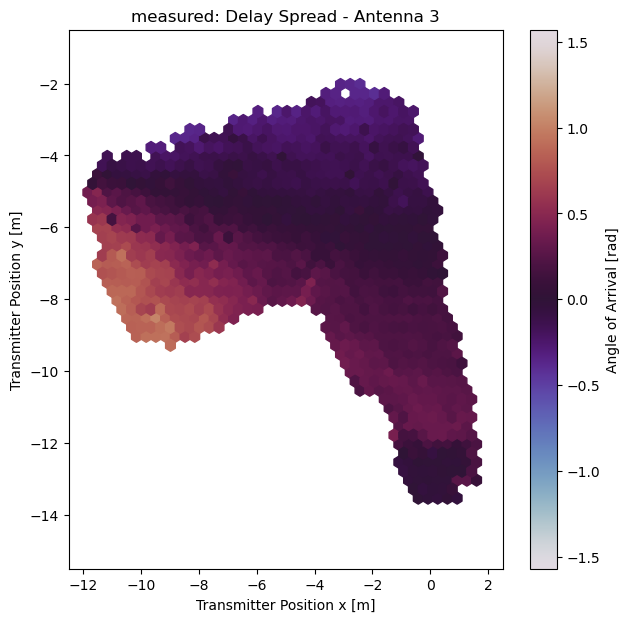

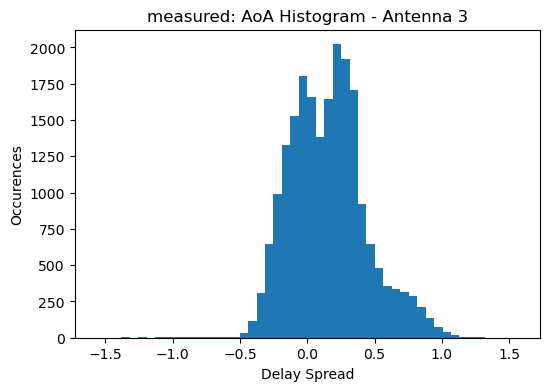

  0%|          | 0/20973 [00:00<?, ?it/s]

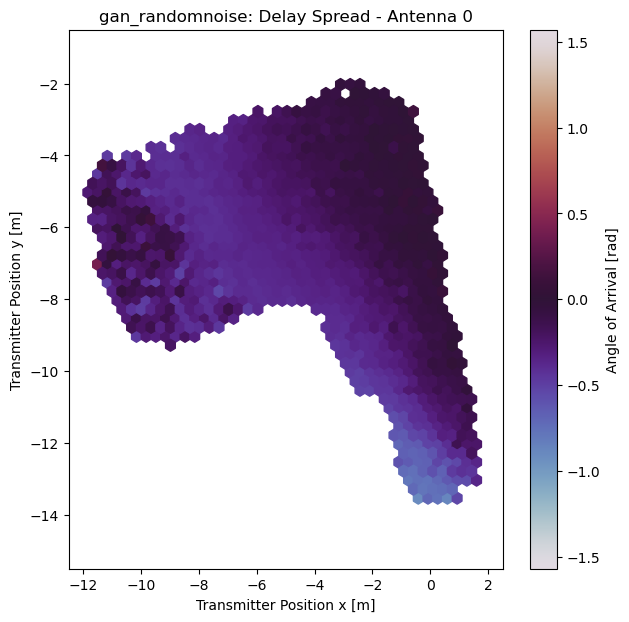

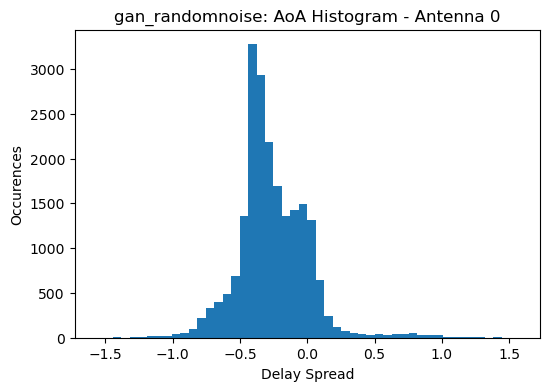

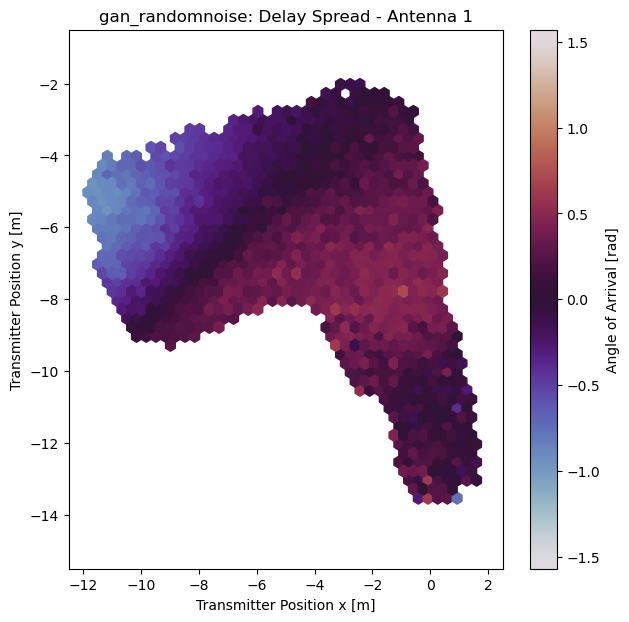

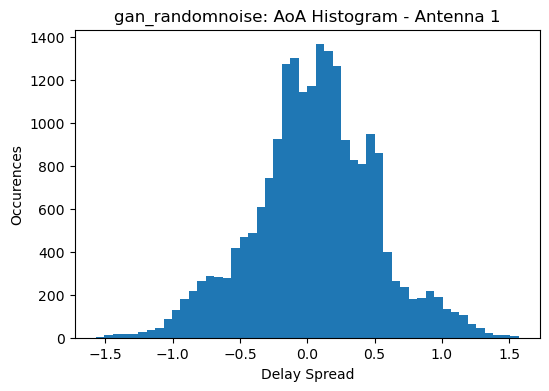

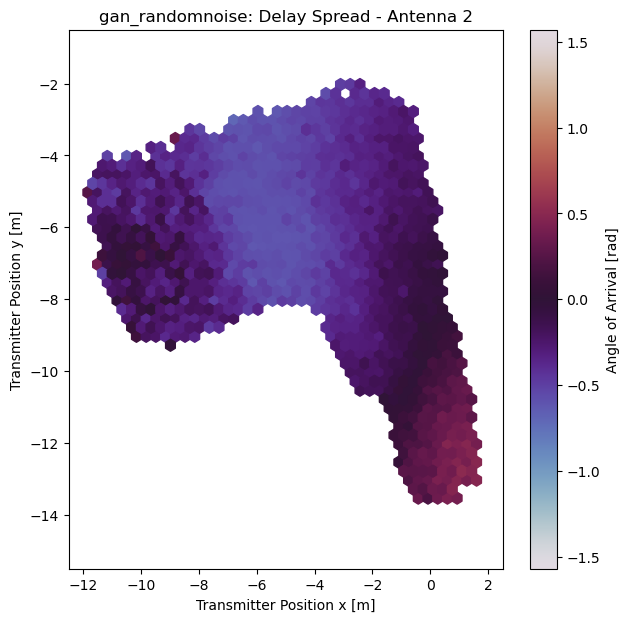

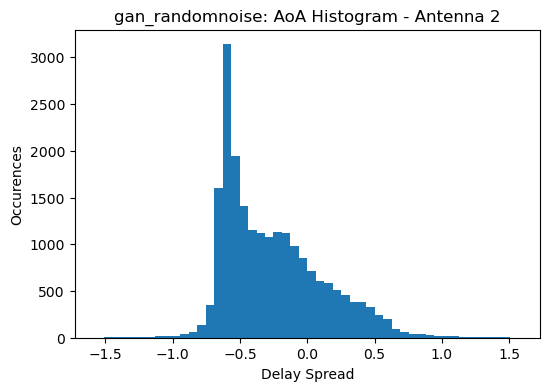

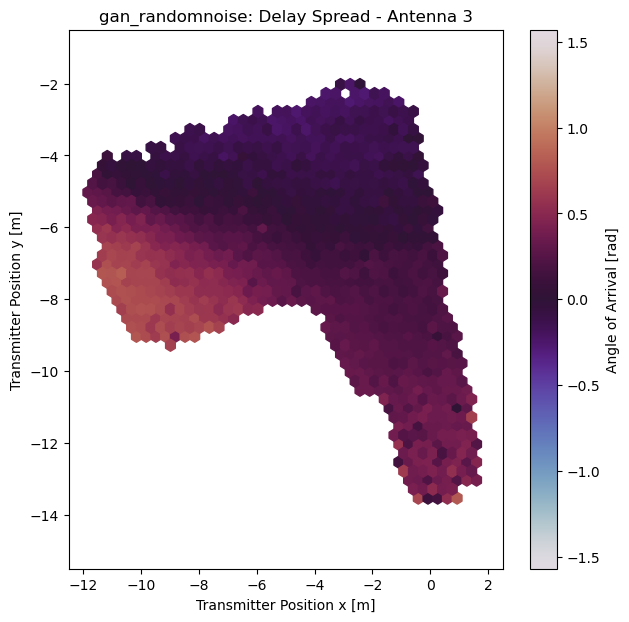

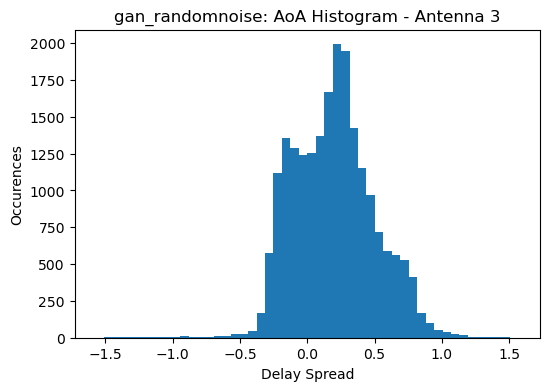

  0%|          | 0/20973 [00:00<?, ?it/s]

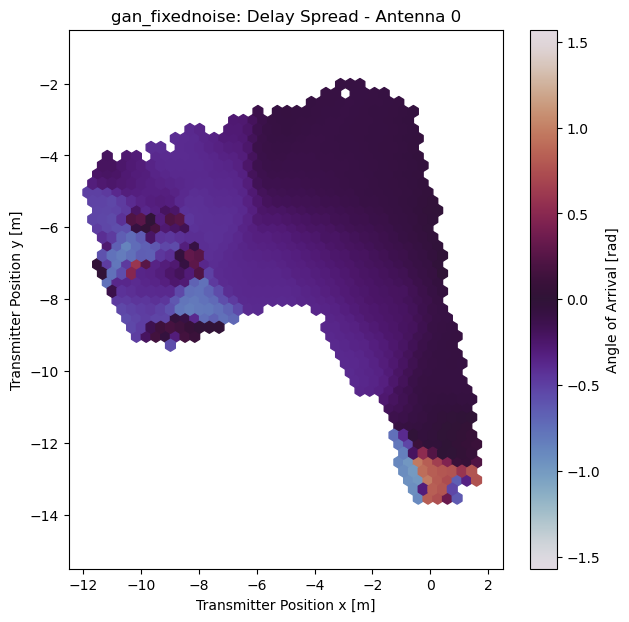

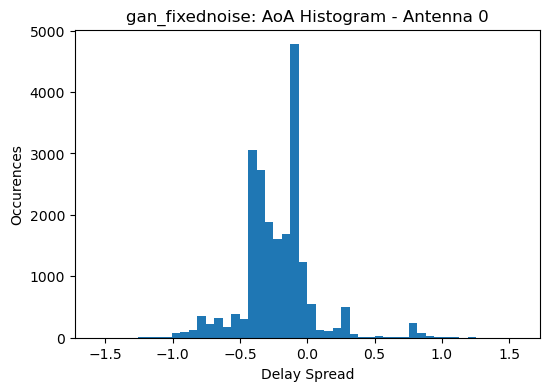

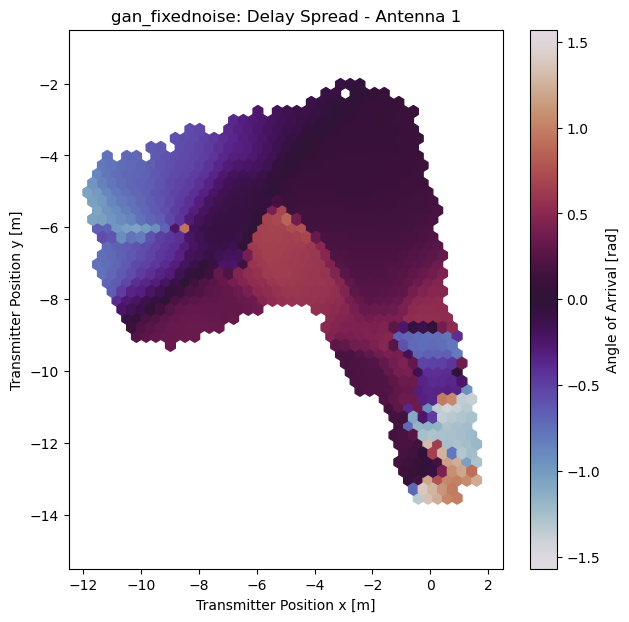

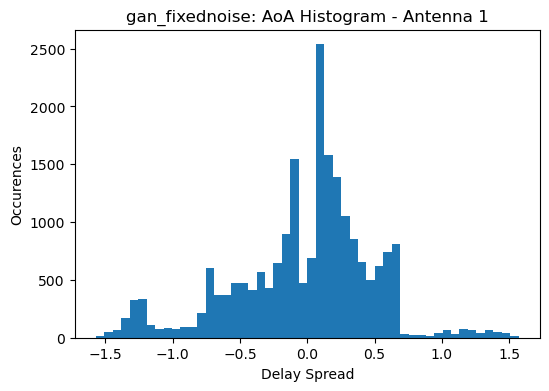

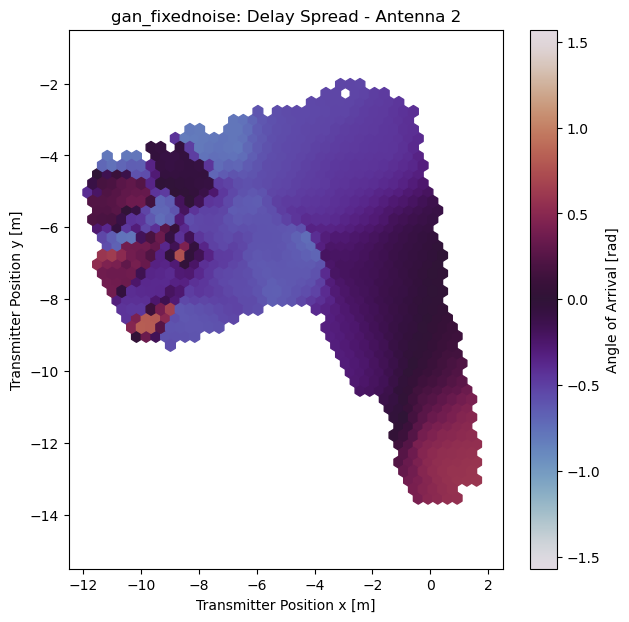

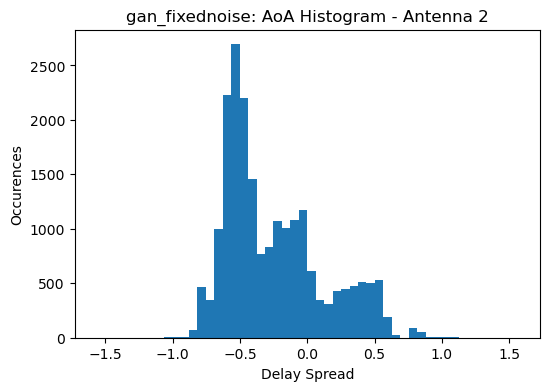

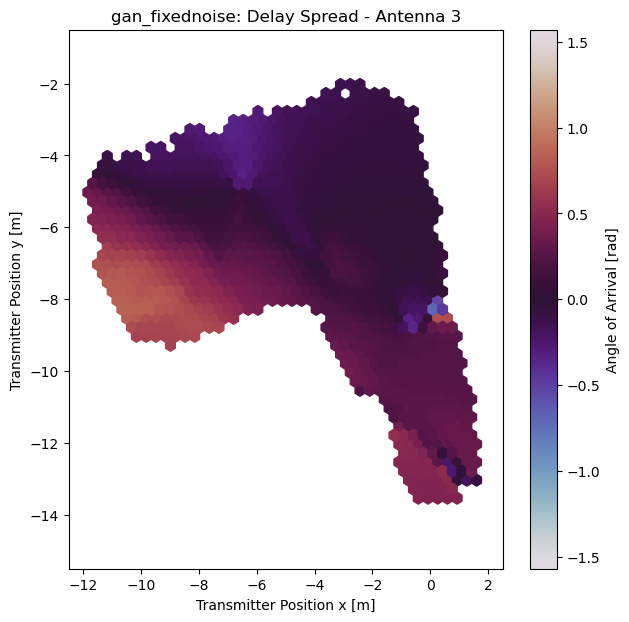

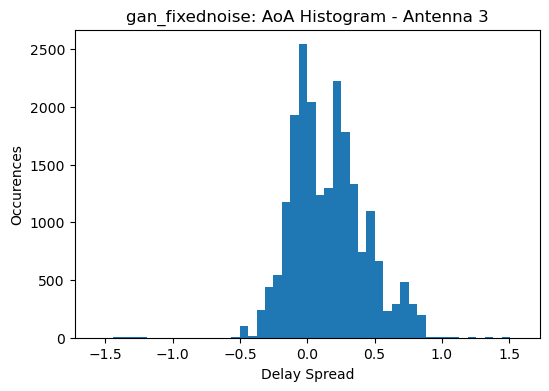

  0%|          | 0/20973 [00:00<?, ?it/s]

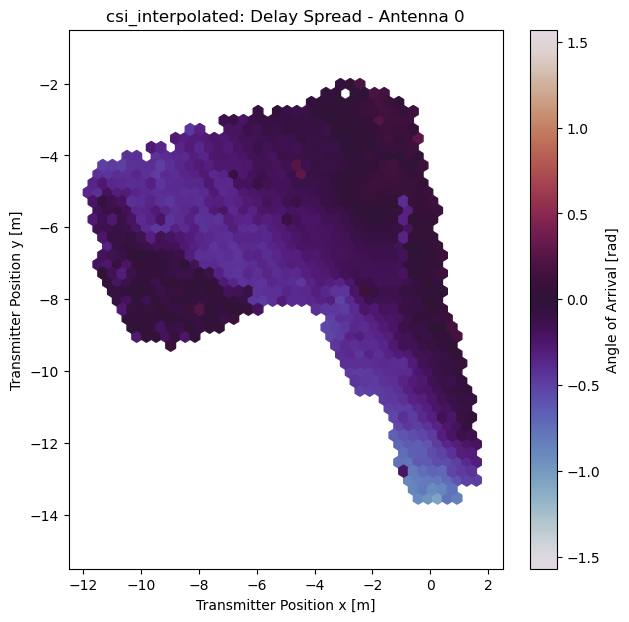

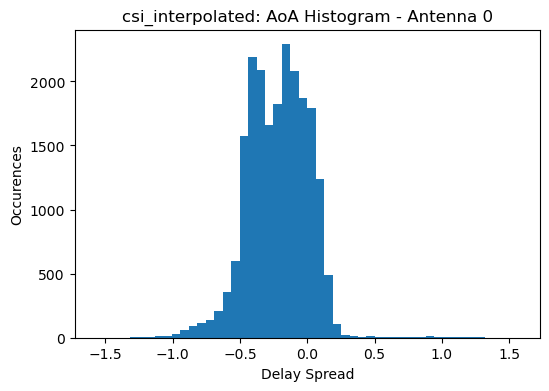

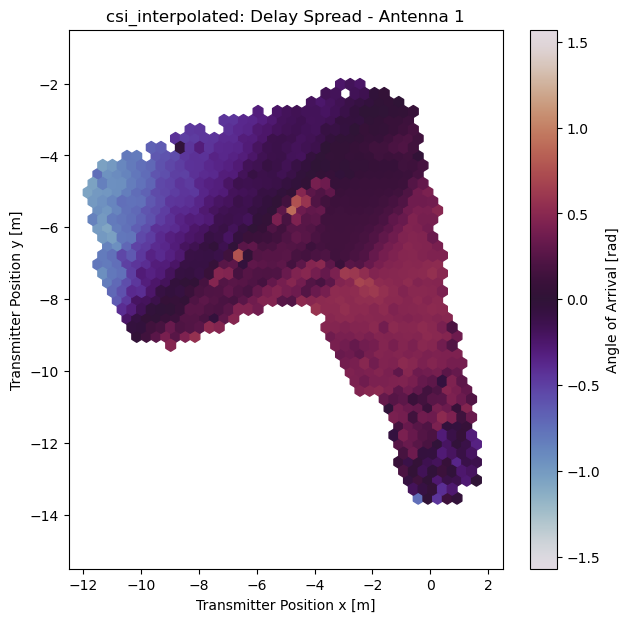

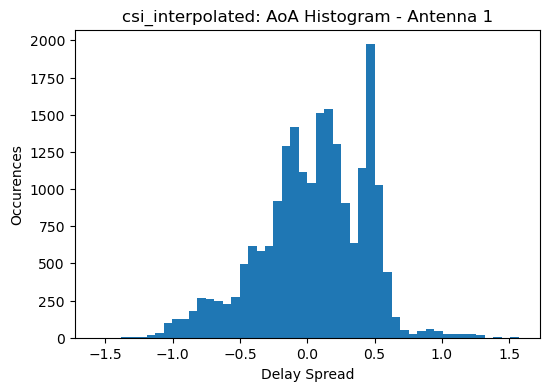

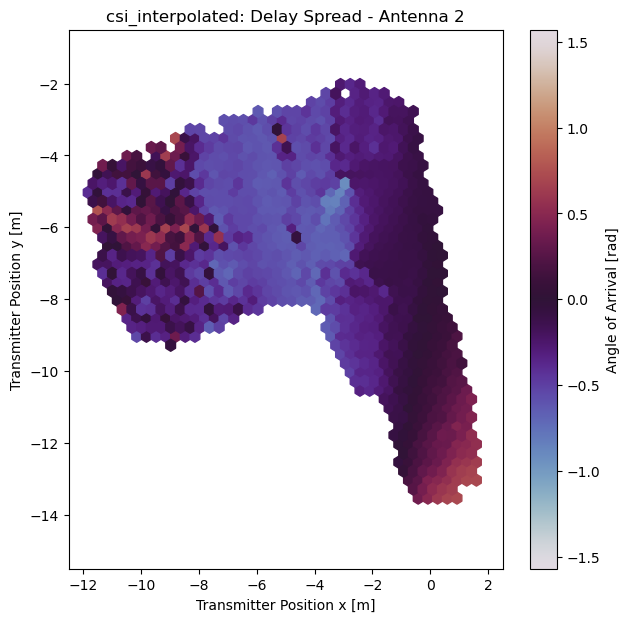

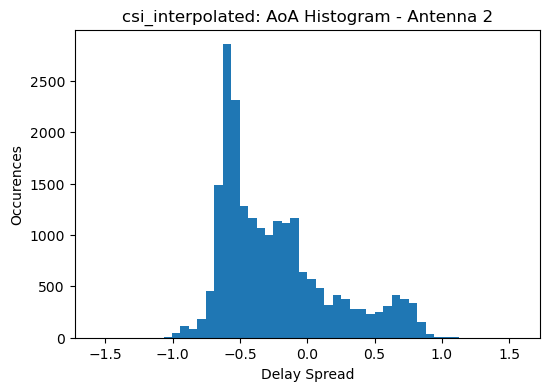

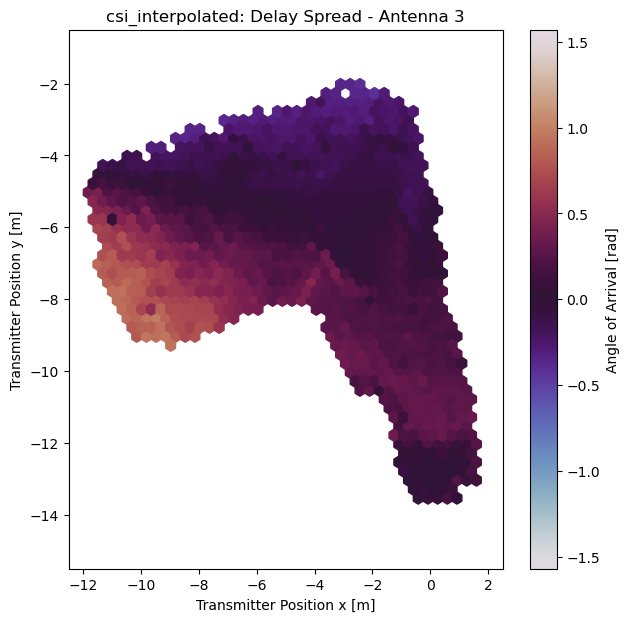

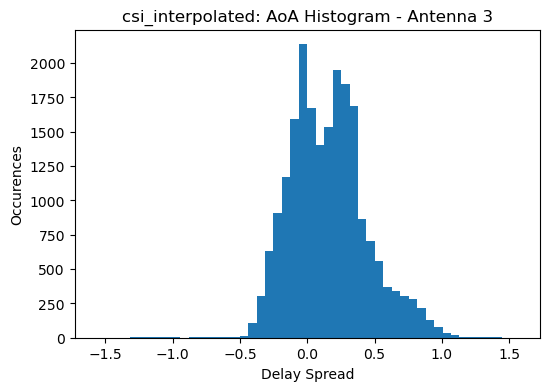

In [7]:
plot_aoa("measured", test_set_positions, test_set_csi)
plot_aoa("gan_randomnoise", test_set_positions, test_set_csi_gan_randomnoise)
plot_aoa("gan_fixednoise", test_set_positions, test_set_csi_gan_fixednoise)
plot_aoa("csi_interpolated", test_set_positions, test_set_csi_interpolated, test_set_csi_interpolated_valid)